# Description
Company XYZ sells a software for 39. Since revenue has been ﬂat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price ($39), while a random sample of 33% users a higher price ($59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:

* Should the company sell its software for 39 or 59?
* The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main ﬁndings looking at the data?

# Index
* [Load the data](#Load-the-data)
* [Check whether test/control group is randomly splitted?](#Check-whether-test-and-control-group-is-randomly-splitted?)
* [Answer question 1](#Answer-question-1)
* [Answer question 2](#Answer-question-2)
    * [Chi-Square test](#Chi-Square-test)
    * [How price affects conversion?](#How-price-affects-conversion?)
    * [How OS affects conversion?](#How-OS-affects-conversion?)
    * [Model by Decision Tree](#Model-by-Decision-Tree)
    * [**Actionable-Insights**](#Actionable-Insights)

In [90]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,f_classif
from sklearn.tree import DecisionTreeClassifier,export_graphviz
import matplotlib.pyplot as plt

In [91]:
plt.style.use('ggplot')
%matplotlib inline

seed = 999

## Load the data

In [92]:
userdata = pd.read_csv('user_table.csv')
userdata.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


User table contains [id,city,country,lat,long] and all values in 'country' column are USA. Users might not provide useful information to the problems, so I just ignored user table.

In [93]:
testdata = pd.read_csv('test_results.csv', index_col = 'user_id')

# rename OS column to make it easier to display
testdata.rename(columns={'operative_system':'OS'}, inplace = True)

testdata.head()

,timestamp,source,device,OS,test,price,converted
user_id,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [94]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316800 entries, 604839 to 832372
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   timestamp  316800 non-null  object
 1   source     316800 non-null  object
 2   device     316800 non-null  object
 3   OS         316800 non-null  object
 4   test       316800 non-null  int64 
 5   price      316800 non-null  int64 
 6   converted  316800 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 19.3+ MB


## Check whether test and control group is randomly splitted

In [95]:
X = testdata.copy()
del X['timestamp']

# to use sklearn to check feature importance, we must convert string values to numbers
src_label_encoder = LabelEncoder()
dev_label_encoder = LabelEncoder()
os_label_encoder = LabelEncoder()

X['source'] = src_label_encoder.fit_transform(testdata.source)
X['device'] = dev_label_encoder.fit_transform(testdata.device)
X['OS'] = os_label_encoder.fit_transform(testdata.OS)

In [96]:
X.head()

,source,device,OS,test,price,converted
user_id,,,,,,
604839,3,0,1,0,39,0
624057,8,0,0,0,39,0
317970,0,0,0,0,39,0
685636,5,0,1,1,59,0
820854,3,1,3,0,39,0


In [97]:
# Run Chi-Square test to see which factor impact the splitting between test/control group
colnames = ['source','device','OS']
chi2values,pvalues = chi2(X.loc[:,colnames],X['test'])
pd.DataFrame({'chi2_value':chi2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
OS,83.085986,7.856065e-20
device,44.366335,2.723301e-11
source,0.924742,3.362329e-01


The above result indicates that the splitting between test/control groups aren't random. OS and device have a great impact on the split.

In [98]:
# Check how the test and control groups are distributed across different operating systems
def calc_ratios(s):
    d = s.value_counts(normalize = True)
    d['total'] = s.shape[0]
    return d
test_ctrl_by_os = testdata.groupby('OS')['test'].apply(calc_ratios).unstack()
test_ctrl_by_os

android,0,1,total
OS,,,
android,0.643358,0.356642,74935.0
iOS,0.647934,0.352066,95465.0
linux,0.533736,0.466264,4135.0
mac,0.652422,0.347578,25085.0
other,0.647865,0.352135,16204.0
windows,0.629764,0.370236,100976.0


In [99]:
os_by_test_ctrl = testdata.groupby('test')['OS'].apply(lambda s: s.value_counts(normalize=True)).unstack()
os_by_test_ctrl

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313678,0.305115,0.237807,0.080729,0.051784,0.010887
1,0.327729,0.294636,0.234280,0.076434,0.050021,0.016901


<Axes: xlabel='test'>

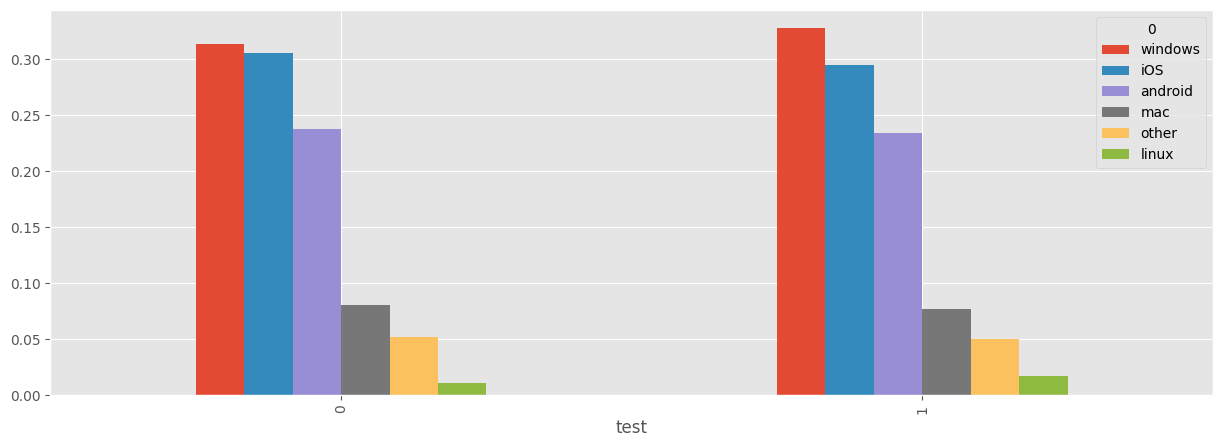

In [100]:
os_by_test_ctrl.plot(kind='bar',figsize=(15,5))

We can see that OS distribution in test/control groups are quite different. The experiment claims that '66% of the users have seen the old price (39), while a random sample of 33% users have seen a higher price (59).', but users from Linux don't follow this rule. 53% were assigned to control group, 47% go to test group.

## Answer question 1
Should the company sell its software for 39 or 59?

In [101]:
# Get revenue
revenues = testdata.groupby(by = 'test').apply(lambda df: df.price * df.converted)
ctrl_revenues = revenues[0]
test_revenues = revenues[1]

In [102]:
def group_statistics(df):
    return pd.Series({'n_users': df.shape[0],
                      'convert_rate': df.converted.mean(), 
                      'mean_revenue': (df.price * df.converted).mean()})
testdata.groupby('test').apply(group_statistics)

,n_users,convert_rate,mean_revenue
test,,,
0,202727.0,0.019904,0.776734
1,114073.0,0.015543,0.916843


We are going to perform a t-test to test whether the test group's average revenue is higher than control group's average revenue
* H0: test group's average revenue equal to control group's average revenue
* HA: test group's average revenue is higher than control group's average revenue

In [103]:
# Get T-test p-value
ttest_result = ss.ttest_ind(test_revenues,ctrl_revenues,equal_var=False)  # ttest_ind is two tailed
ttest_result.pvalue/2   # since our HA is test_mean > ctrl_mean, so we need to divide by 2

7.703749302339191e-09

Since the p-value is much smaller than 0.05 threshold, so we reject H0, and accept HA. It means the test group's average revenue is significantly higher than control group's average revenue.

However, as OS distribution is not the same between test/control groups (#linux_imbalance), price isn't the only difference between test/control groups, so we cannot contribute the increase in average revenue to price.

Since the experiment design fails, it's hard to decide whether to sell software to all users in 59 dollars. The future work could be: 
1. find the reason why linux users have different representation ratio than other OS
2. then run the experiment again, and make sure price is the only difference between test and control group
3. run t-test again, to see whether the average revenue is significantly improved

## Answer question 2
The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main ﬁndings looking at the data?

In [104]:
X.head()

,source,device,OS,test,price,converted
user_id,,,,,,
604839,3,0,1,0,39,0
624057,8,0,0,0,39,0
317970,0,0,0,0,39,0
685636,5,0,1,1,59,0
820854,3,1,3,0,39,0


### Chi-Square test

In [105]:
# Run Chi-Square test to see which features greatly impact converted rate
colnames = ['source','device','OS','price']
chi2values,pvalues = chi2(X.loc[:,colnames],X['converted'])
pd.DataFrame({'chi2_value':chi2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
price,150.992849,1.051844e-34
OS,7.642955,5.699447e-03
source,2.373391,1.234187e-01
device,0.729490,3.930485e-01


Chi-Square test result indicates:
* Price and OS are two main factors which impact converted or not 
* Source and Device don't impact conversion rate that much.

### How price affects conversion?

In [106]:
converted_by_price= testdata.groupby('price')['converted'].apply(lambda s: s.value_counts(normalize=True)).unstack()
converted_by_price

39,0,1
price,,
39,0.980111,0.019889
59,0.984430,0.015570


The users that see 59 dollar have lower conversion rate than the users see 39 dollars.
### How OS affects conversion?

In [107]:
converted_by_os = testdata.groupby('OS')['converted'].apply(lambda s: s.value_counts(normalize=True)).unstack()
converted_by_os.sort_values(by=1,ascending=False)

android,0,1
OS,,
mac,0.976002,0.023998
iOS,0.977678,0.022322
windows,0.983045,0.016955
android,0.985067,0.014933
other,0.987040,0.012960
linux,0.991778,0.008222


In [108]:
os_by_converted = testdata.groupby('converted')['OS'].apply(lambda s: s.value_counts(normalize=True)).unstack()
os_by_converted

,android,iOS,linux,mac,other,windows
converted,,,,,,
0,0.237357,0.300117,0.013187,0.078725,0.051429,0.319185
1,0.192665,0.366908,0.005854,0.103650,0.036157,0.294766


<Axes: xlabel='converted'>

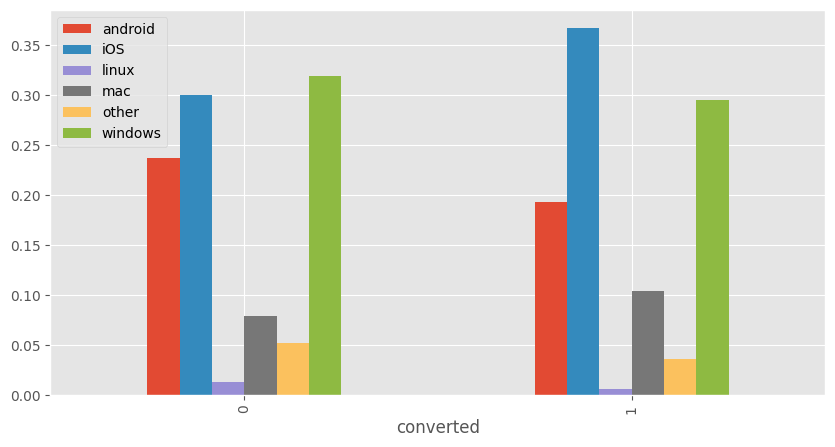

In [109]:
os_by_converted.plot(kind='bar',figsize=(10,5))

<Axes: >

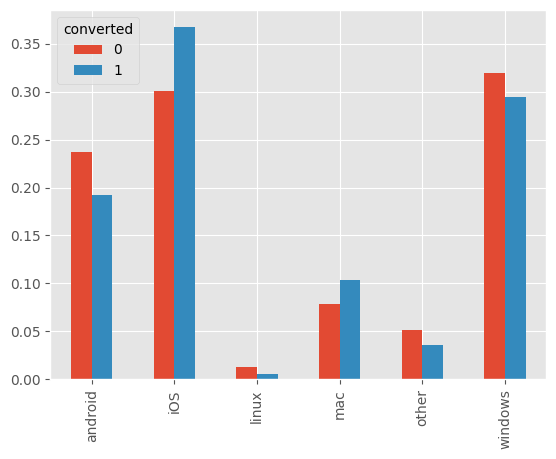

In [110]:
os_by_converted.transpose().plot(kind='bar')

From the above result, we can see
Mac and iOS users have higher conversion rate than users from other OS.
Linux users have the lowest conversion rate among all the OS users.

### Model by Decision Tree
A Decision Tree was built to get feature importance. Since the question is asking about 'actionable insight' other than a model which precisely predicts conversion, the model's performance on test set was not provided.

In [111]:
testdata.head(10)

,timestamp,source,device,OS,test,price,converted
user_id,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0
169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39,0
600150,2015-03-04 14:45:44,seo_facebook,web,windows,0,39,0
798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1
447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59,0


In [112]:
X = testdata.copy()
del X['timestamp']
del X['test']

In [113]:
X.source.value_counts()

source
direct_traffic     60357
ads-google         59379
ads_facebook       53396
ads_other          29876
seo-google         23175
ads-bing           22873
seo_facebook       21205
friend_referral    20695
seo-other           9260
ads-yahoo           7583
seo-yahoo           6848
seo-bing            2153
Name: count, dtype: int64

In [114]:
X.device.value_counts()

device
mobile    186471
web       130329
Name: count, dtype: int64

In [115]:
X.OS.value_counts()

OS
windows    100976
iOS         95465
android     74935
mac         25085
other       16204
linux        4135
Name: count, dtype: int64

In [116]:
# One-Hot-Encoding on categorical features
X = pd.get_dummies(X).astype(int)

# Drop one category for each feature manually instead of using 'drop_first' parameter in get_dummies
del X['source_ads_other']
del X['device_web']
del X['OS_other']

In [117]:
X.head()

,price,converted,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,OS_android,OS_iOS,OS_linux,OS_mac,OS_windows
user_id,,,,,,,,,,,,,,,,,,,
604839,39,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
624057,39,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
317970,39,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
685636,59,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
820854,39,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [118]:
Xtrain = X.loc[:,X.columns != 'converted']
ytrain = X.loc[:,'converted']

In [119]:
Xtrain.head()

,price,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,OS_android,OS_iOS,OS_linux,OS_mac,OS_windows
user_id,,,,,,,,,,,,,,,,,,
604839,39,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
624057,39,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
317970,39,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
685636,59,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
820854,39,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


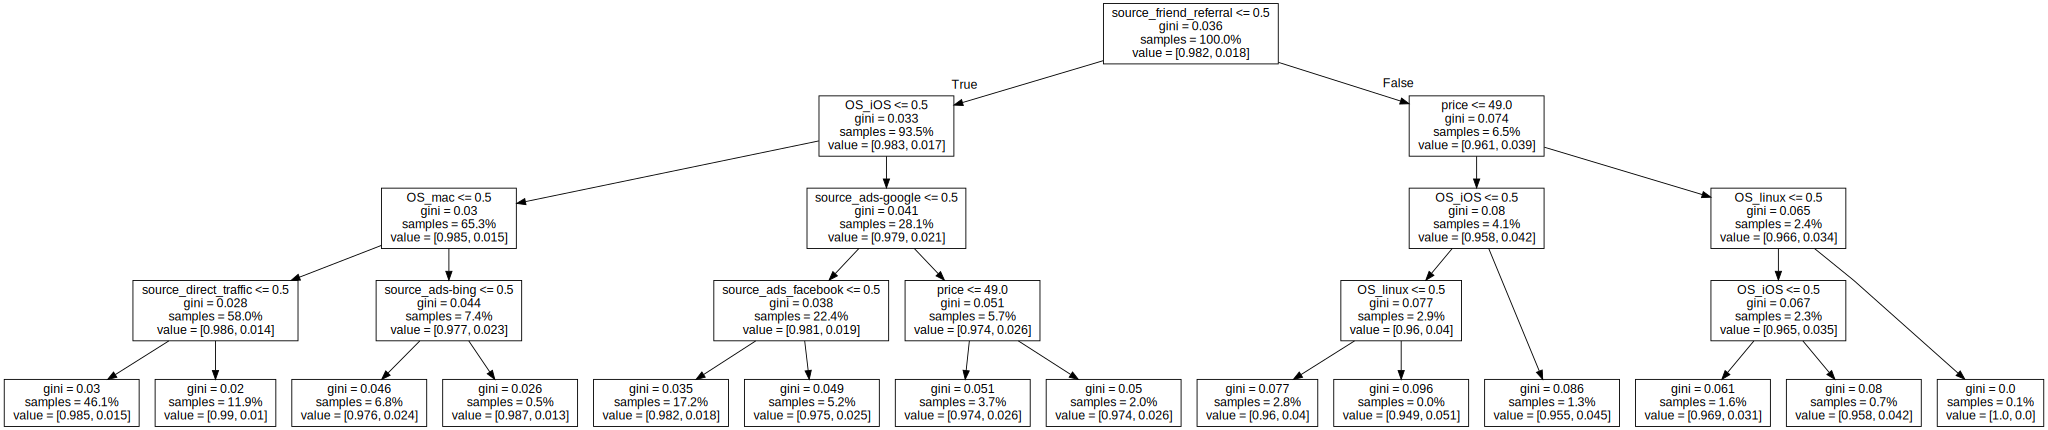

In [120]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(Xtrain,ytrain)
dot_data = export_graphviz(dt,feature_names=Xtrain.columns, proportion=True, leaves_parallel=True)

import graphviz
treeplot = graphviz.Source(dot_data, format='png') 
treeplot.render('decision_tree')
treeplot

From the tree plot, we can see that, to reach the leaf node with highest conversion rate (the fourth leaf from right with conversion rate=0.045), the path is:
1. source 'friend_referral' = true
2. price <= 49, i.e., price = 39
3. OS 'iOS'= true

In [121]:
pd.Series(dt.feature_importances_,index = Xtrain.columns).sort_values(ascending=False)

source_friend_referral    0.582278
OS_iOS                    0.136605
OS_mac                    0.093907
source_direct_traffic     0.059002
source_ads_facebook       0.041034
source_ads-google         0.038543
price                     0.020118
OS_linux                  0.018002
source_ads-bing           0.010511
device_mobile             0.000000
OS_android                0.000000
source_seo-other          0.000000
source_seo_facebook       0.000000
source_seo-yahoo          0.000000
source_seo-google         0.000000
source_seo-bing           0.000000
source_ads-yahoo          0.000000
OS_windows                0.000000
dtype: float64

### Actionable Insights

* Friend_referral, Apple user (MAC or iOS), low price are three great positive factors which improve the conversion rate
* if we want to increase the price, which impacts negatively on conversion rate, we must compensate on the other two factors
    * launch special marketing program targeted to Apple users (MAC or iOS users)
    * run some programs which reward users when they invite his/her friends to use our software
* Linux users don't like our software as much as the users on other OS. Development team needs to find out the reason.